##### import statements

In [36]:
from classes.Classifiers.Classifiers import Classifiers
from classes.Classifiers.ClassBalancer import ClassBalancer
from classes.Classifiers.FeatureSelector import FeatureSelector
from classes.Classifiers.ModelComparison import ModelComparison
from classes.Utils.PandasUtils import PandasUtils

In [37]:
#numerical
import numpy as np
import pandas as pd
import math
from glob import glob 

#os related operations
import os 
from os import listdir
from os.path import isfile, join

#data structures
from collections import Counter
from itertools import chain
from itertools import islice

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')


In [38]:
#sklearn
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import SelectKBest, chi2,f_classif 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve  

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC #multiclass
from sklearn.linear_model import LogisticRegression #multiclass
from sklearn.ensemble import RandomForestClassifier #multilabel, multioutput
from sklearn.tree import DecisionTreeClassifier  #multilabel, multioutput
from sklearn.ensemble import GradientBoostingClassifier #multiclass

#### set path

In [39]:
path = os.getcwd()
results_path = os.path.join(path,'results','single-label-classification','')
features_path = os.path.join(path,'features','')

In [40]:
if os.path.exists(results_path):
    pass
else:
    os.mkdir(results_path)

In [41]:
# results are stored in a dict
acc_default = {}
f1score_default = {}

In [42]:
content = 'code'
setting = '_'+content+'_'+'scaled'
settings = [m+setting for m in ['rf','dt','gb','lsvc','svc','log'] ]

for model_name in settings:
    acc_default[model_name] = {}
    f1score_default[model_name] = {}

### Load Data

In [43]:
test_features = pd.read_pickle(features_path+'test_features.pkl')
train_features = pd.read_pickle(features_path+'train_features.pkl')
validation_features = pd.read_pickle(features_path+'validation_features.pkl')
#print(train_features.isna().sum())
train_features.index = range(train_features.shape[0])
validation_features.index = range(validation_features.shape[0])
test_features.index = range(test_features.shape[0])

train_features.fillna(0,inplace=True)
test_features.fillna(0,inplace=True)
validation_features.fillna(0,inplace=True)
print(train_features.isna().sum())
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

filename                0
cell_type               0
cell_number             0
execution_count         0
linesofcomment          0
linesofcode             0
variable_count          0
function_count          0
text/plain              0
image/png               0
text/html               0
execute_result          0
display_data            0
stream                  0
error                   0
text                    0
comment                 0
code_line_before        0
code_line_after         0
markdown_heading        0
packages_info           0
primary_label           0
helper_functions        0
load_data               0
data_exploration        0
data_preprocessing      0
evaluation              0
modelling               0
prediction              0
result_visualization    0
save_results            0
comment_only            0
dtype: int64
(5833, 32)
(1927, 32)
(1918, 32)


#### labels

In [44]:
labels = ['helper_functions','load_data',
              'data_preprocessing','data_exploration',
              'modelling','evaluation','prediction',
              'result_visualization','save_results',
              'comment_only']

#### training + validation dataset!

In [45]:
df = pd.DataFrame()
#df= df.add(features)
#df = df.add(train_features)
#df = df.add(validation_features)
#df.shape
df = pd.concat([df, train_features,  validation_features], axis=0)

# Reset index if needed
df = df.reset_index(drop=True)

print(df)

             filename cell_type  cell_number  execution_count  linesofcomment  \
0      nb_54880.ipynb      code            0                1             0.0   
1      nb_54880.ipynb      code            1                2             1.0   
2      nb_54880.ipynb      code            2                3             0.0   
3      nb_54880.ipynb      code            3                4             0.0   
4      nb_54880.ipynb      code            4                5             0.0   
...               ...       ...          ...              ...             ...   
7755  nb_750781.ipynb      code           28               12             0.0   
7756  nb_750781.ipynb      code           30               16             0.0   
7757  nb_750781.ipynb      code           32                8             0.0   
7758  nb_750781.ipynb      code           35               19             0.0   
7759  nb_750781.ipynb      code           38               19             0.0   

      linesofcode  variable

In [46]:
df

,filename,cell_type,cell_number,execution_count,linesofcomment,linesofcode,variable_count,function_count,text/plain,image/png,...,helper_functions,load_data,data_exploration,data_preprocessing,evaluation,modelling,prediction,result_visualization,save_results,comment_only
0,nb_54880.ipynb,code,0,1,0.0,2.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,nb_54880.ipynb,code,1,2,1.0,4.0,4.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,nb_54880.ipynb,code,2,3,0.0,1.0,0.0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,nb_54880.ipynb,code,3,4,0.0,1.0,0.0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,nb_54880.ipynb,code,4,5,0.0,1.0,1.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7755,nb_750781.ipynb,code,28,12,0.0,1.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
7756,nb_750781.ipynb,code,30,16,0.0,5.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
7757,nb_750781.ipynb,code,32,8,0.0,3.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
7758,nb_750781.ipynb,code,35,19,0.0,10.0,4.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [47]:
print("Total notebook in training+validation: ",len(set(df.filename.values)))
print("Total notebook in test: ",len(set(test_features.filename.values)))

Total notebook in training+validation:  376
Total notebook in test:  94


### Classifier Setup and Feature Engineering

### Data Preprocessing

#### Categorisation of features 
*if necessary

In [48]:
def categorize(df):
    cat = pd.Categorical(df['primary_label'].values, categories=labels)
    y, uniques = pd.factorize(cat)
    df['primary_label'] = np.asarray(y)
    
    cat = pd.Categorical(df['filename'].values)
    files, uniques = pd.factorize(cat)
    df['filename'] = np.asarray(files)
    
    return df,files,cat

In [49]:
temp_df = pd.DataFrame()
#temp_df = temp_df.add(df.copy())
temp_df = pd.concat([df, temp_df, test_features], axis=0)

# Reset index if needed
temp_df = temp_df.reset_index(drop=True)
#temp_df = temp_df.add(test_features.copy())
print(temp_df)
temp_df.index = range(temp_df.shape[0])
temp_df,cat,files = categorize(temp_df)

df1 = temp_df[0:df.shape[0]].copy()
df1.index = range(df1.shape[0])
print(df1.primary_label.unique())
print(df1.shape)

df2 = temp_df[df.shape[0]:].copy()
df2.index = range(df2.shape[0])
print(df2.primary_label.unique())
print(df2.shape)

            filename cell_type  cell_number  execution_count  linesofcomment  \
0     nb_54880.ipynb      code            0                1             0.0   
1     nb_54880.ipynb      code            1                2             1.0   
2     nb_54880.ipynb      code            2                3             0.0   
3     nb_54880.ipynb      code            3                4             0.0   
4     nb_54880.ipynb      code            4                5             0.0   
...              ...       ...          ...              ...             ...   
9673  nb_96779.ipynb      code           45               -1             0.0   
9674  nb_96779.ipynb      code           47               -1             0.0   
9675  nb_96779.ipynb      code           48               -1             0.0   
9676  nb_96779.ipynb      code           51               -1             0.0   
9677  nb_96779.ipynb      code           53               -1             0.0   

      linesofcode  variable_count  func

##### for a pre-defined split of validation set for crossfold validation

In [50]:
test_fold = []
for i in range(0,train_features.shape[0]):
    test_fold.append(0)

In [51]:
len(test_fold)

5833

In [52]:
folds = {}
t_fold = 1
count = 1
for each in set(validation_features.filename.values):
    folds[each] = t_fold 
    if count%10 == 0:
        t_fold += 1
    count += 1

In [53]:
len(folds)

94

In [54]:
for idx,row in validation_features.iterrows():
    test_fold.append(folds[row['filename']])

In [55]:
len(test_fold)

7760

##### set the split

In [56]:
ps = PredefinedSplit(test_fold=test_fold)
print(set(test_fold))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


#### Set up the classifier and indicate conditions to restrict the dataframe we will be working on

In [57]:
model = Classifiers(df1,labels)

conditions = (df1.cell_type == 'code')   #not needed because our dataframe already has only code datapoints
model.apply_conditions_to_dataframe(conditions) #a new dataframe #df_restricted will be created internally

(train,test,indices_train,indices_test)=model.test_train_data_set(df2)

Shape of the restricted dataframe:  (7760, 32)
Resetting index.
train.shape,test.shape
(7760, 32) (1918, 32)


In [58]:
model.train

,filename,cell_type,cell_number,execution_count,linesofcomment,linesofcode,variable_count,function_count,text/plain,image/png,...,helper_functions,load_data,data_exploration,data_preprocessing,evaluation,modelling,prediction,result_visualization,save_results,comment_only
index,,,,,,,,,,,,,,,,,,,,,
0,0,code,0,1,0.0,2.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,code,1,2,1.0,4.0,4.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,code,2,3,0.0,1.0,0.0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,code,3,4,0.0,1.0,0.0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,code,4,5,0.0,1.0,1.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7755,375,code,28,12,0.0,1.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
7756,375,code,30,16,0.0,5.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
7757,375,code,32,8,0.0,3.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [59]:
df1.isna().sum()

filename                0
cell_type               0
cell_number             0
execution_count         0
linesofcomment          0
linesofcode             0
variable_count          0
function_count          0
text/plain              0
image/png               0
text/html               0
execute_result          0
display_data            0
stream                  0
error                   0
text                    0
comment                 0
code_line_before        0
code_line_after         0
markdown_heading        0
packages_info           0
primary_label           0
helper_functions        0
load_data               0
data_exploration        0
data_preprocessing      0
evaluation              0
modelling               0
prediction              0
result_visualization    0
save_results            0
comment_only            0
dtype: int64

In [60]:
labels

['helper_functions',
 'load_data',
 'data_preprocessing',
 'data_exploration',
 'modelling',
 'evaluation',
 'prediction',
 'result_visualization',
 'save_results',
 'comment_only']

### Feature Engineering (Representation and Selection)

the important feature is the code itself and other features (extended/contextual, comment, code statistics are considered supplementary features in our task) 

In [61]:
#'text','comment','code_line_before','code_line_after', 'markdown_heading', 'packages_info'
features = ['text']
train,test = model.set_lexical_features(features) #same df is modified and contains our new feature column *new_text*

new (lexical) feature column created as 'new_text'


In [62]:
train

,filename,cell_type,cell_number,execution_count,linesofcomment,linesofcode,variable_count,function_count,text/plain,image/png,...,load_data,data_exploration,data_preprocessing,evaluation,modelling,prediction,result_visualization,save_results,comment_only,new_text
index,,,,,,,,,,,,,,,,,,,,,
0,0,code,0,1,0.0,2.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,"[import pandas as pd, import numpy as np]"
1,0,code,1,2,1.0,4.0,4.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,"[l_cols = ['user_id','movie_id','rating'], r_c..."
2,0,code,2,3,0.0,1.0,0.0,0.0,1,0,...,0,1,0,0,0,0,0,0,0,[l.head()]
3,0,code,3,4,0.0,1.0,0.0,0.0,1,0,...,0,1,0,0,0,0,0,0,0,[r.head()]
4,0,code,4,5,0.0,1.0,1.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,"[movies = pd.merge(l,r)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7755,375,code,28,12,0.0,1.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,[print(num_mistakes_dict['177'][1])]
7756,375,code,30,16,0.0,5.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,"[print(num_mistakes_dict['279'][1]), print(""--..."
7757,375,code,32,8,0.0,3.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,"[print(num_mistakes_dict['2854'][1]), print(""-..."


#### apply preprocessing to the text feature
we will use code_text_processing function to process our lexical feature *new_text* we created previously and store them in *text_processed*

In [63]:
train,test = model.preprocessing('new_text')

In [64]:
dir(model)
print(model.train_X)


None


##### tfidf and chi2

In [65]:
#vectorize the text (lexical) in 'text_processed' column
tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,max_df=0.2,min_df=2,stop_words='english') 
X_train,X_test,tfidf = model.vectorization(tfidf)

#use feature selection if necessary (pass k and training label)
k = 1000 #k lexical features to be retained
X_train_features,X_test_features,selector = model.feature_selection(chi2,k,train.primary_label.values)

tfidf transformation finished. shape of the feature vector:  (7760, 48485) (1918, 48485)
Selecting 1000 features...
train,test shape
(7760, 1000) (1918, 1000)


In [66]:
#tfidf_features = tfidf.get_feature_names()
tfidf_features = tfidf.get_feature_names_out()
print("tfidf features: ",len(tfidf_features))
print("before feature selection: ",len(selector.get_support()))
selected_features = selector.get_support()
text_features = [tfidf_features[i] for i in range(len(tfidf.get_feature_names_out())) if selected_features[i]==True]
print("after feature selection: ",len(text_features))

tfidf features:  48485
before feature selection:  48485
after feature selection:  1000


In [67]:
#following set of features are represented in numerical form
#metric features are: ['linesofcomment','linesofcode','variable_count','function_count']
#extended features are: ['filename','cell_number','execution_count','text/plain' , 'image/png', 'text/html', 'execute_result', 'display_data', 'stream', 'error']

stat_features = ['linesofcomment','linesofcode','variable_count','function_count']
X_train_features_,X_test_features_ = model.set_statistical_features(stat_features,X_train_features,X_test_features)

taking feature  linesofcomment   (7760, 1001)
taking feature  linesofcode   (7760, 1002)
taking feature  variable_count   (7760, 1003)
taking feature  function_count   (7760, 1004)
taking feature  linesofcomment   (1918, 1001)
taking feature  linesofcode   (1918, 1002)
taking feature  variable_count   (1918, 1003)
taking feature  function_count   (1918, 1004)
statistical features added


#### Together, text_features and stat_features form the original feature vector of our model

In [68]:
feature_vector = text_features+stat_features
len(feature_vector)

1004

#### Standardize the features 
since our statistical features are scaled in a different way to our text vectors

In [69]:

from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_features_ = ss.fit_transform(X_train_features_)
X_test_features_ = ss.transform(X_test_features_)


In [112]:
print(feature_vector)

['2f', '2f format', '__version__', 'accs_test', 'accuracy', 'accuracy 2f', 'accuracy 2f format', 'accuracy plt', 'accuracy_score', 'accuracy_score ytest', 'accuracy_score ytest y_model', 'accurate2', 'activation', 'activation relu', 'add', 'all_values', 'alpha', 'alpha plt', 'amboy', 'anime', 'annotation', 'antitosvm', 'apply', 'argmax', 'argmax preds', 'argmax y_pred', 'argmax y_pred dimension', 'avenue', 'avenue distance', 'average', 'ax', 'axes', 'axis', 'batch', 'batch_size', 'best_score_', 'bins', 'borough', 'borough bronx pnyc', 'borough brooklyn', 'borough brooklyn filtered_pluto', 'borough manhattan', 'borough manhattan pnyc', 'borough queens', 'borough queens pnyc', 'borough staten', 'borough staten island', 'boulevard', 'boulevard distance', 'broadway', 'bronx pnyc', 'brooklyn', 'brooklyn filtered_pluto', 'brooklyn filtered_pluto borough', 'builder', 'census', 'census csv', 'child cup', 'child cup split', 'chkp', 'classification_report', 'classification_report y_true', 'class

## Classifier Model

## 1. Compare Classifiers 
*default params

In [70]:
ks = [k] 
print(setting)
for k in ks:
    model_pipelines = [('rf',Pipeline([('clf', RandomForestClassifier(random_state=500))])),
                       ('dt',Pipeline([('clf', DecisionTreeClassifier(random_state=500))])),
                       ('gb',Pipeline([('clf', GradientBoostingClassifier(random_state=500))])),
                       ('lsvc',Pipeline([('clf', LinearSVC(random_state=500))])),
                       ('svc',Pipeline([('clf', SVC(random_state=500))])),
                       ('log',Pipeline([('clf', LogisticRegression(random_state=500))])),
                       ]
    
    for pipe in model_pipelines:
        model_name = pipe[0]
        pipeline = pipe[1]
        print('model: ',model_name, k)

        # Singlelabel classifier
        model = OneVsRestClassifier(pipeline).fit(X_train_features_,train['primary_label'])
        prediction = model.predict(X_test_features_)
        acc = accuracy_score(test['primary_label'], prediction)
        model_name = model_name+setting
        acc_default[model_name][k] = acc
        f1score = metrics.f1_score(test['primary_label'], prediction, average = 'weighted')
        f1score_default[model_name][k] = f1score
        print(' acc: ', acc, 'f1score: ', f1score)


_code_scaled
model:  rf 1000
 acc:  0.7106360792492179 f1score:  0.7029370860842276
model:  dt 1000
 acc:  0.5714285714285714 f1score:  0.5957588972841119
model:  gb 1000
 acc:  0.6934306569343066 f1score:  0.6848556784735591
model:  lsvc 1000
 acc:  0.6548488008342023 f1score:  0.6423958034493278
model:  svc 1000
 acc:  0.6595411887382691 f1score:  0.6494170709387062
model:  log 1000
 acc:  0.6418143899895725 f1score:  0.6253374118206392


In [71]:
pd.DataFrame.from_dict(f1score_default).to_pickle(results_path+'f1score_default.pkl')
pd.DataFrame.from_dict(acc_default).to_pickle(results_path+'acc_default.pkl')

### Analysis of results

In [72]:
acf = pd.DataFrame()
f1f = pd.DataFrame()
f1 = pd.read_pickle(results_path+'f1score_default.pkl')
a1 = pd.read_pickle(results_path+'acc_default.pkl')

In [114]:
print(a1.filter)

<bound method NDFrame.filter of       rf_code_scaled  dt_code_scaled  gb_code_scaled  lsvc_code_scaled  \
1000        0.710636        0.571429        0.693431          0.654849   

      svc_code_scaled  log_code_scaled  
1000         0.659541         0.641814  >


In [73]:
pd.DataFrame(acc_default).max().max()
pd.DataFrame(f1score_default).max().max()

0.7029370860842276

In [96]:
for each in ['code-stat_','code-extend-proper_','all-features_','_no-code','code_','code-comment_']:
    cols = a1[a1.filter(like=each).columns]
    print(cols)
    for col in cols:
        acf[col] = a1[col]

for each in ['code-stat_','code-extend-proper_','all-features_','_no-code','code_','code-comment_']:
    cols = f1[f1.filter(like=each).columns]
    for col in cols:
        f1f[col] = f1[col]

Empty DataFrame
Columns: []
Index: [1000]
Empty DataFrame
Columns: []
Index: [1000]
Empty DataFrame
Columns: []
Index: [1000]
Empty DataFrame
Columns: []
Index: [1000]
      rf_code_scaled  dt_code_scaled  gb_code_scaled  lsvc_code_scaled  \
1000        0.710636        0.571429        0.693431          0.654849   

      svc_code_scaled  log_code_scaled  
1000         0.659541         0.641814  
Empty DataFrame
Columns: []
Index: [1000]


In [75]:
my_data = f1f[f1f >= f1f.max().max()].to_numpy()
for idrow, row in enumerate(my_data):
    for idcol, col in enumerate(row):
        if not pd.isnull(col):
            print("f1 Value :"+str(col)+" column:"+str(idcol)+" row:"+str(idrow),f1f.columns[idcol],f1f.index[idrow])
            
my_data = acf[acf >= acf.max().max()].to_numpy()
for idrow, row in enumerate(my_data):
    for idcol, col in enumerate(row):
        if not pd.isnull(col):
            print("acc Value :"+str(col)+" column:"+str(idcol)+" row:"+str(idrow),acf.columns[idcol],acf.index[idrow])

f1 Value :0.7029370860842276 column:0 row:0 rf_code_scaled 1000
acc Value :0.7106360792492179 column:0 row:0 rf_code_scaled 1000


In [76]:
f1score_dict, acc_dict = {},{}

for col in f1f.T[1000].index.values:
    f1score_dict[col] = round(f1f[col][1000],3)
    acc_dict[col] = round(acf[col][1000],3)

In [79]:
slabel = pd.DataFrame({'model':f1score_dict.keys(),'accuracy':acc_dict.values(),'f1score':f1score_dict.values()})
slabel.index = slabel['model']
slabel.to_pickle(results_path+'single_label_results.pkl')
slabel

,model,accuracy,f1score
model,,,
rf_code_scaled,rf_code_scaled,0.711,0.703
dt_code_scaled,dt_code_scaled,0.571,0.596
gb_code_scaled,gb_code_scaled,0.693,0.685
lsvc_code_scaled,lsvc_code_scaled,0.655,0.642
svc_code_scaled,svc_code_scaled,0.660,0.649
log_code_scaled,log_code_scaled,0.642,0.625


In [117]:
unique_values, counts = np.unique(train["primary_label"], return_counts=True)

print(counts)
import pickle
file_path = 'C:\\Users\\lukas\\OneDrive\\Dokumente\\tuwien\\MachineLearning\\exdds\\features\\train_features.pkl'

with open(file_path, 'rb') as file:
    # Load the object from the file
    loaded_object = pickle.load(file)

print(loaded_object)

[ 614  575 2288 1842 1233  394  296  143  197  178]
            filename cell_type  cell_number  execution_count  linesofcomment  \
0     nb_54880.ipynb      code            0                1             0.0   
1     nb_54880.ipynb      code            1                2             1.0   
2     nb_54880.ipynb      code            2                3             0.0   
3     nb_54880.ipynb      code            3                4             0.0   
4     nb_54880.ipynb      code            4                5             0.0   
...              ...       ...          ...              ...             ...   
5828  nb_95821.ipynb      code           27               -1             0.0   
5829  nb_95821.ipynb      code           29               -1             0.0   
5830  nb_95821.ipynb      code           31               -1             0.0   
5831  nb_95821.ipynb      code           33               -1             5.0   
5832  nb_95821.ipynb      code           35               -1        

## 2. Best parameters using GridSearchCV


In [ ]:
results = {}
accuracy_all = {}
f1_score_all = {}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

parameters = {'rf':{}}
parameters['rf']['estimator__rf__criterion'] = ['gini','entropy']
parameters['rf']['estimator__rf__n_estimators'] = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
parameters['rf']['estimator__rf__class_weight']= ['balanced', 'balanced_subsample']

In [ ]:
k = 1000
print("******",k,"*******")
model_pipelines = [('rf',Pipeline([('rf', RandomForestClassifier(random_state=500))]))]
    
for pipe in model_pipelines:
    model_name = pipe[0]+'['+content+']'
    pipeline = pipe[1]
    print('model: ',model_name, ' :: ', 'pipeline: ', pipeline)
           
    CV = GridSearchCV(OneVsRestClassifier(pipeline), parameters[pipe[0]], scoring = 'accuracy', n_jobs= 1,cv=ps)
    CV.fit(X_train_features_,train['primary_label'])
    prediction_single = CV.predict(X_test_features_)
    print(' acc: ', accuracy_score(test['primary_label'], prediction_single))
    print(' f1score: ', metrics.f1_score(test['primary_label'], prediction_single, average = 'weighted'))


****** 1000 *******
model:  rf[code]  ::  pipeline:  Pipeline(steps=[('rf', RandomForestClassifier(random_state=500))])
 acc:  0.7022940563086548
 f1score:  0.692680874234164


In [ ]:
print(classification_report(test['primary_label'], prediction_single, target_names=labels))

                      precision    recall  f1-score   support

    helper_functions       0.83      0.77      0.80       154
           load_data       0.75      0.71      0.73       158
  data_preprocessing       0.73      0.77      0.75       591
    data_exploration       0.63      0.81      0.71       432
           modelling       0.68      0.66      0.67       316
          evaluation       0.52      0.28      0.37        95
          prediction       0.48      0.17      0.25        60
result_visualization       0.88      0.50      0.64        30
        save_results       0.90      0.40      0.55        45
        comment_only       1.00      0.86      0.93        37

            accuracy                           0.70      1918
           macro avg       0.74      0.59      0.64      1918
        weighted avg       0.70      0.70      0.69      1918



results saved in  c:\Users\lukas\OneDrive\Dokumente\tuwien\MachineLearning\exdds\results\single-label-classification\


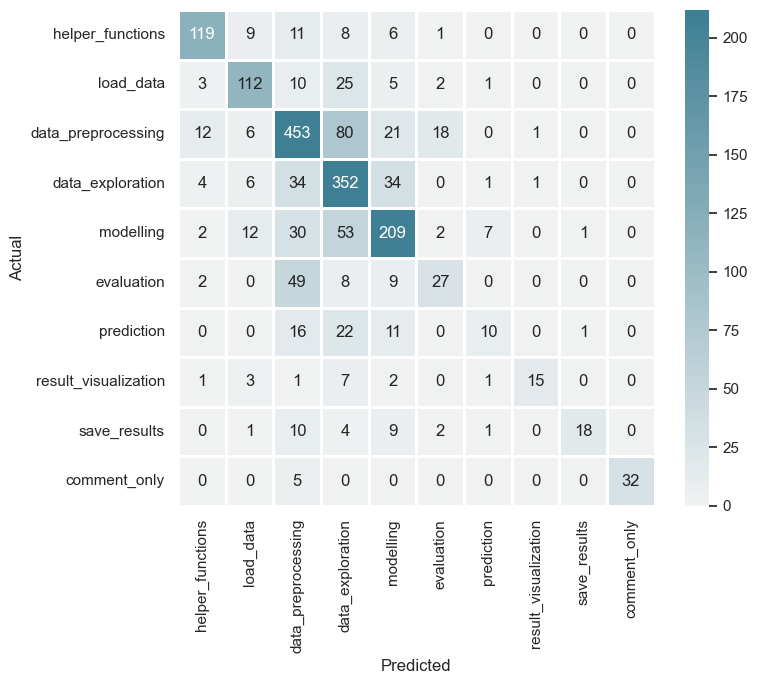

In [ ]:
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(confusion_matrix(test['primary_label'], prediction_single)
                    , annot=True, fmt='d',
            cmap=sns.diverging_palette(20, 220, n=200),
            linewidths = 1,robust=True, center=0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion matrix - Single label RF Classifier'
#ax.set_title(title,fontsize=15,fontweight='bold')
ax.set_yticklabels(labels,rotation=0)
ax.set_xticklabels(labels,rotation=90)
fig.tight_layout()
ax.figure.savefig(results_path+'singlelabelconfusion.eps', format='eps')
print("results saved in ",results_path)
plt.show()
